In [1]:
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import grad, vmap, jit
from tqdm.notebook import tqdm as t

ModuleNotFoundError: No module named 'tqdm'

In [ ]:
N_samples = 500

In [ ]:
ref_smpl = np.random.randn(N_samples,2)

xx = np.random.randn(1, N_samples)
zz = np.random.randn(1, N_samples)
# draw samples from target obtained by y = x^2 + z, x,z ~ N(0,1)
tar_smpl = np.concatenate( (xx, np.power(xx, 2) + 0.3*zz), 1 ).reshape(2,N_samples).T

plt.scatter(*ref_smpl.T, label = 'reference')
plt.scatter(*tar_smpl.T, label = 'target')
plt.legend()

In [ ]:
#first, operator valued kernel

In [ ]:
g = 1

In [ ]:
MM = jnp.array([[1,0],[0,1]])

In [ ]:
def K(x, y, gamma = g):
    #x in R^n, y in R^n
    #outputs a 2x2 matrix 
    return MM*1/(1+jnp.dot(x-y,x-y)*gamma)

Kvec = vmap(vmap(K, in_axes=(None, 0)), in_axes=(0, None))

@jit
def OpK(x, y, gamma = 1):
    M = Kvec(x, y) #Somewhat magic code for Op valued kernels 
    M = jnp.swapaxes(M,1,2) 
    return M.reshape(2*M.shape[0],2*M.shape[2])

We are looking for functions $f: \mathcal X = \mathbb R^2 \mapsto \mathbb R^2 = \mathcal Y$ 


$$f^\dagger = \textrm{argmin}_{f \in H} \lambda \Vert f \Vert^2_K + \textrm{MMD}(X + f(X), Y)$$ 

by the Representer theorem, $f(\cdot) = K(\cdot, X)K(X ,X)^{-1}Z$, where $Z \in \mathcal Y^n$ minimizes
$$ \min_{Z \in \mathcal Y^n} \lambda z^t K(X,X)^{-1}z + \textrm{MMD}(X + Z, Y) $$ 

In [ ]:
#Coding the objective function for MMD with random features

In [ ]:
Nfeatures = 600
kappa = np.sqrt(2/Nfeatures)

bs = np.random.uniform(low = 0, high = 2*np.pi, size = Nfeatures)
ws = np.random.normal(size = (Nfeatures,2))


In [ ]:
def phi(x):
    #x is in R^2, phi(x) is in R^Nfeatures
    return kappa*jnp.cos(ws@x + bs)

In [ ]:
phi_vec = jit(vmap(phi))

In [ ]:
def MMD(A, B):
    #A is [n, 2]
    #B is [m, 2]
    #MMD(A, B) is a number
    return jnp.linalg.norm(jnp.mean(phi_vec(A), axis = 0) - jnp.mean(phi_vec(B), axis = 0))

In [ ]:
Kxx = OpK(ref_smpl, ref_smpl)

In [ ]:
Kxxinv = jnp.linalg.inv(Kxx+1e-4*jnp.eye(len(Kxx)))

In [ ]:
λ = 1e-5
@jit
def objective_function(z):
    #z is in R^{dx * n_points}
    return λ * z.T@Kxxinv@z + MMD(ref_smpl + z.reshape(N_samples, 2), tar_smpl)

In [ ]:
from jax.scipy.optimize import minimize

In [ ]:
z_0 = jnp.zeros(N_samples*2)
res = minimize(objective_function, z_0, method='BFGS', tol =1e-3)

In [ ]:
print(res.success)

True


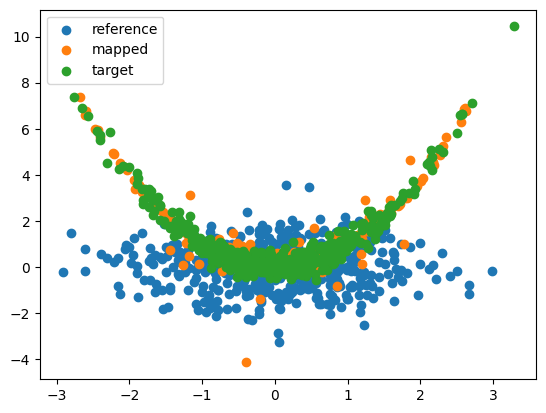

In [ ]:
plt.scatter(*ref_smpl.T, label = 'reference')
plt.scatter(*(ref_smpl +res.x.reshape(N_samples, 2)).T, label = 'mapped')
plt.scatter(*tar_smpl.T, label = 'target')
plt.legend()